In [1]:
%load_ext dotenv
%dotenv ../../05_src/.env
%dotenv ../../05_src/.secrets

In [2]:
import sys
sys.path.append('../../05_src/')

In [3]:
from langchain.chat_models import init_chat_model
model = init_chat_model(
    "openai:gpt-4o-mini",
    temperature=0.7
)

In [4]:
from langchain.tools import tool
import requests
import json

@tool
def get_cat_facts(n:int=1):
    """
    Returns n cat facts from the Meowfacts API.
    """
    url = "https://meowfacts.herokuapp.com/"
    params = {
        "count": n
    }
    response = requests.get(url, params=params)
    resp_dict = json.loads(response.text)
    facts_list = resp_dict.get("data", [])
    facts = "\n".join([f"{i+1}. {fact}\n" for i, fact in enumerate(facts_list)])
    return facts

@tool
def get_dog_facts(n:int=1):
    """
    Returns n dog facts from the Dog API.
    """
    url = "http://dogapi.dog/api/v2/facts"
    params = {
        "limit": n
    }
    response = requests.get(url, params=params)
    resp_dict = json.loads(response.text)
    facts_list = resp_dict.get("data", [])
    facts = "\n".join([f"{i+1}. {fact['attributes']['body']}\n" for i, fact in enumerate(facts_list)])
    return facts



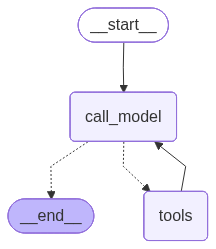

In [24]:
from langsmith import traceable
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt.tool_node import ToolNode, tools_condition

from langchain.agents import create_agent

from langchain.chat_models import init_chat_model

client = MultiServerMCPClient(
    {
        "music_server": {
            # make sure you start your music server on port 8000
            "url": "http://sciuroid-jackeline-overventurously.ngrok-free.dev/mcp",
            "transport": "streamable_http",
        }
    }
)
tools = await client.get_tools()

dev_prompt = """
    You are a helpful assistant tasked with offering music recommendations. 
    Use the music_server when a user asks for a recommendation. 
    Respond with the tool's output directly.
"""


chat_agent = init_chat_model(
    "openai:gpt-4o-mini"
)

@traceable(run_type="llm")
def call_model(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    response = chat_agent.bind_tools(tools).invoke(state["messages"])
    return {
        "messages": [response]
    }

builder = StateGraph(MessagesState)
builder.add_node(call_model)
builder.add_node(ToolNode(tools))
builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model",
    tools_condition,
)
builder.add_edge("tools", "call_model")
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


# response = await graph.invoke({"messages": "what is a good album?"})
# response["messages"]

In [ ]:
from langchain_core.messages import HumanMessage
response =  await graph.invoke({'messages': HumanMessage(content="what is a good album?")})
# response["messages"]

NotImplementedError: StructuredTool does not support sync invocation.

In [ ]:

# Augment the LLM with tools
tools = [get_cat_facts, get_dog_facts] + mcp_tools
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [ ]:
from langchain_core.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [ ]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))



In [ ]:
# Invoke
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Tell me 3 things about cats."), 
            HumanMessage(content="Now tell me 2 things about dogs."),
            HumanMessage(content="What is a good indie album?")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()